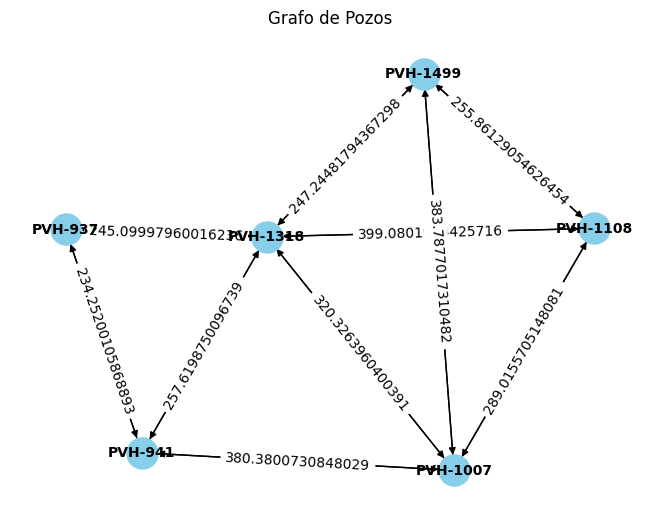

In [1]:
from graph_setup import G
from calc_functions import profiles_comparison, optimal_window, windows_test, calc_tops

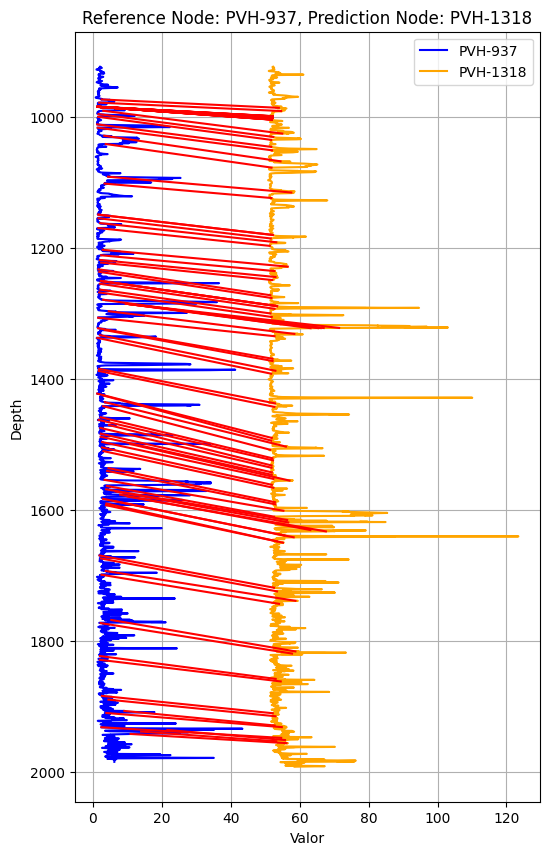

In [2]:
node_name1 = "PVH-937"
node_name2 = "PVH-1318"

data1 = G.nodes[node_name1]["data"].copy()
data2 = G.nodes[node_name2]["data"].copy()
tops1 = G.nodes[node_name1]["known_tops"].copy()

profiles_comparison(data1, data2, tops1, name1=node_name1, name2=node_name2)

Now that everything works, I need to find the optimal windows so that windows_test returns minimal error, I think I will just be looking at mae right now

In [3]:
node_name1 = "PVH-937"
node_name2 = "PVH-1318"
bounds = [(900, 1200), (1800, 2000), (900, 1200), (1800, 2000)]

opt, error = optimal_window(G, node_name1, node_name2, bounds)

print(f"Optimal windows: {opt}")
print(f"Minimum mse: {error}")


100%|██████████| 50/50 [01:39<00:00,  1.99s/trial, best loss: 6.052500000000002]
Optimal windows: [910.0, 1923.5, 948.0, 1987.5]
Minimum mse: 6.052500000000002


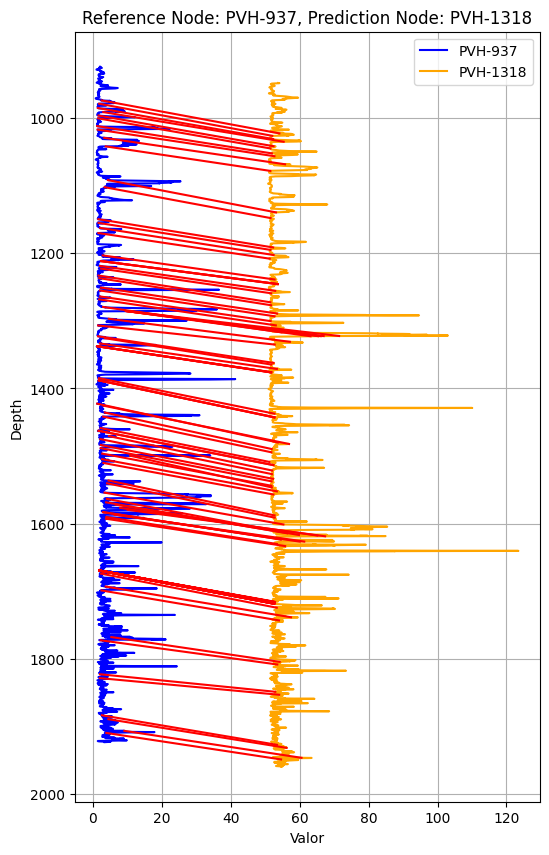

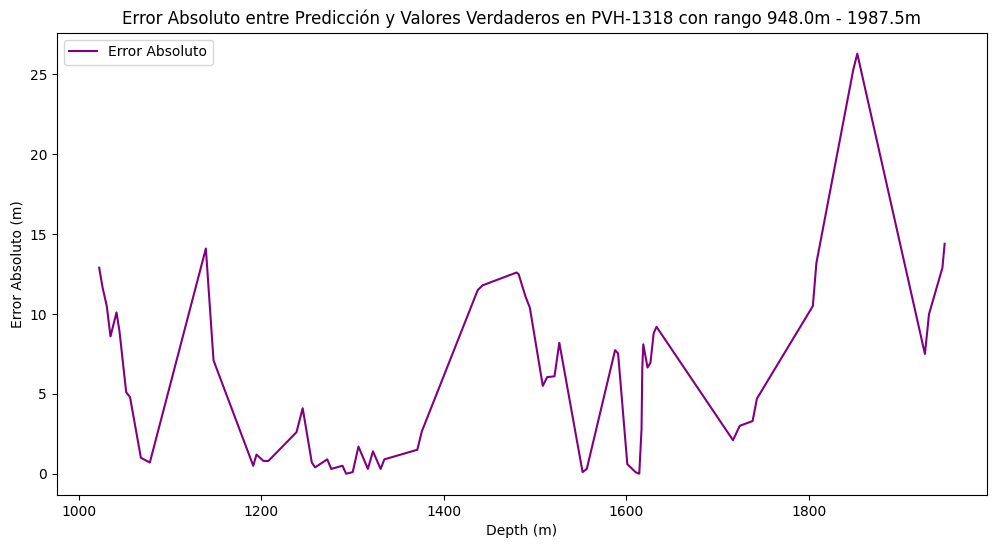

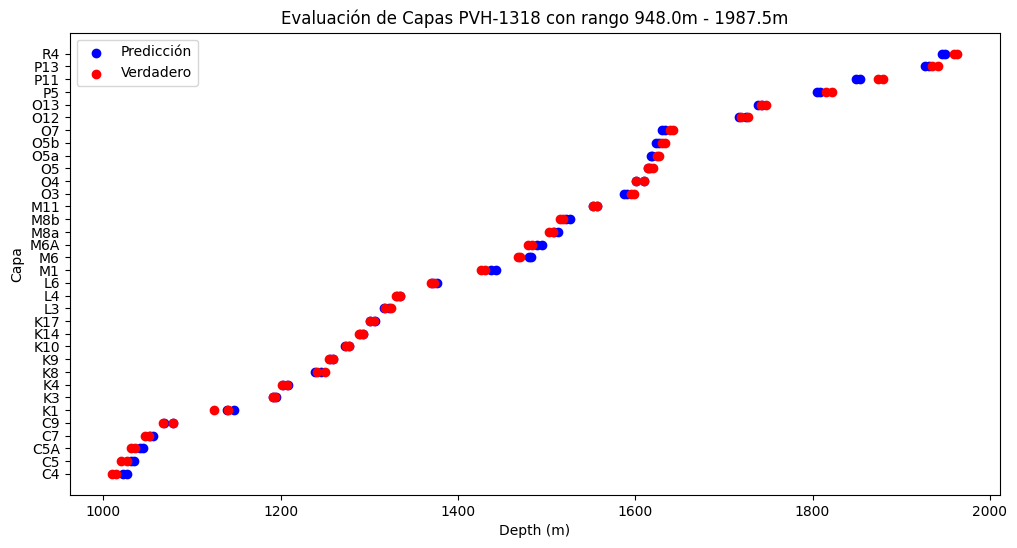

(6.052500000000002, 68.86027205882358)

In [4]:
windows_test(G, node_name1, node_name2, opt, show_plots=True)

Now that we have found the optimal window, we can expand to the rest of the graph

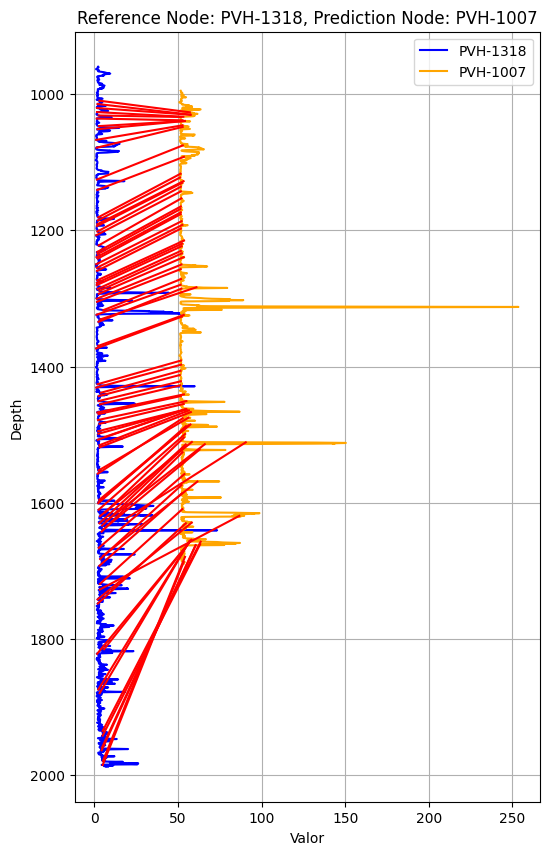

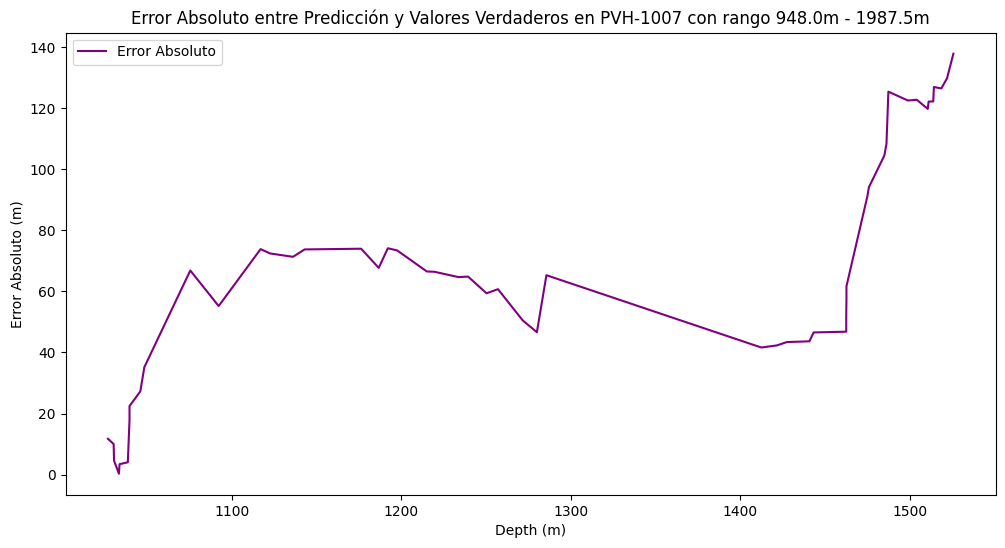

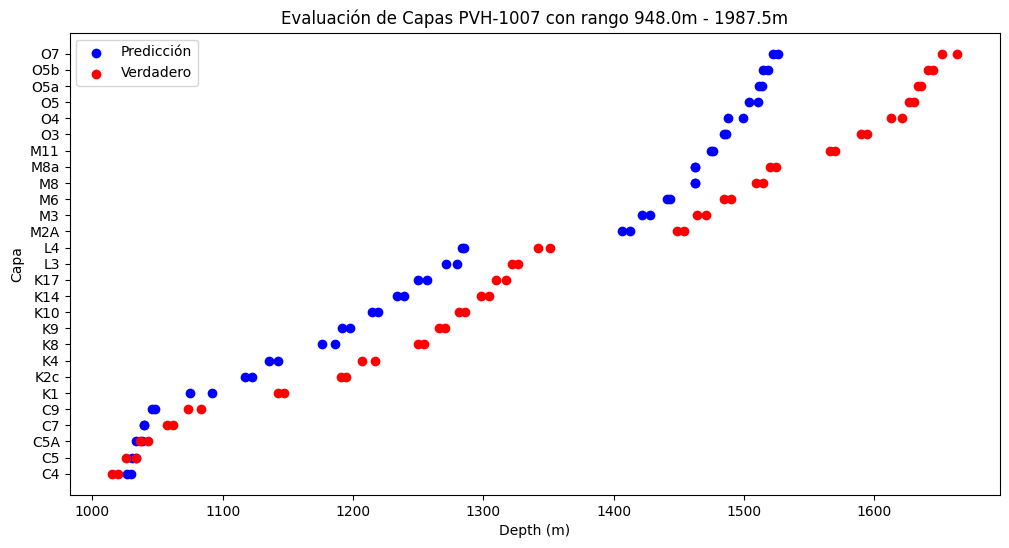

(66.21435185185194, 5755.343344907422)

In [5]:
start_node = node_name2
bound1 = opt[2]
bound2 = opt[3]
w = [bound1, bound2, bound1, bound2]

new_node = "PVH-1007"
calc_tops(G, start_node, new_node, window=w)
windows_test(G, start_node, new_node, w, show_plots=True)



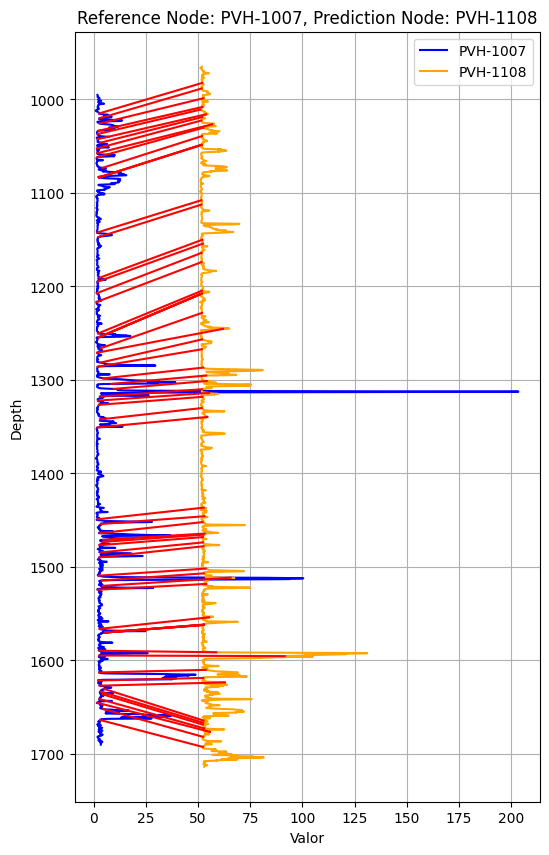

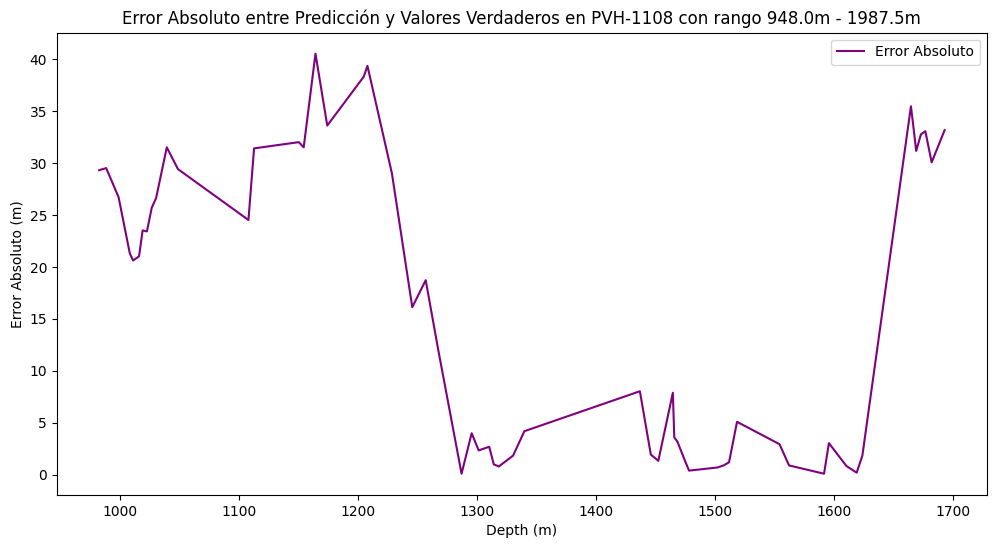

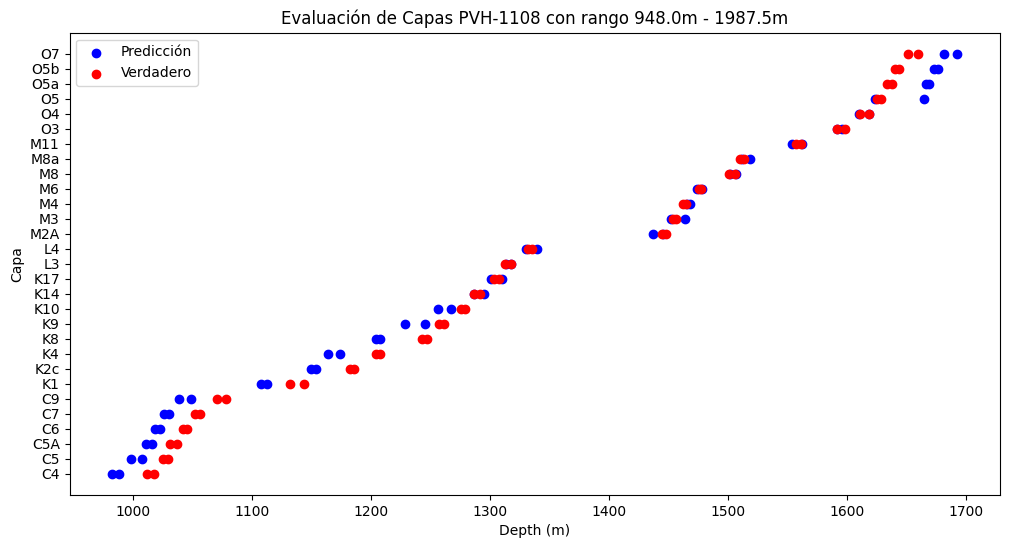

(16.330931034482763, 463.2390472082762)

In [6]:
start_node = "PVH-1007"
bound1 = opt[2]
bound2 = opt[3]
w = [bound1, bound2, bound1, bound2]

new_node = "PVH-1108"
calc_tops(G, start_node, new_node, window=w)
windows_test(G, start_node, new_node, w, show_plots=True)


Disastrous results, need to train algorithm to find correct window

In [7]:
# This function will take several minutes to run
from solve_functions import train_window

t = ["PVH-1499", "PVH-1318", "PVH-1007" ]
train_window(G, t)


Calculating optimal window between PVH-1499 and PVH-1007...
  4%|▍         | 2/50 [00:06<02:34,  3.22s/trial, best loss: 104.0496527777778]


KeyboardInterrupt: 

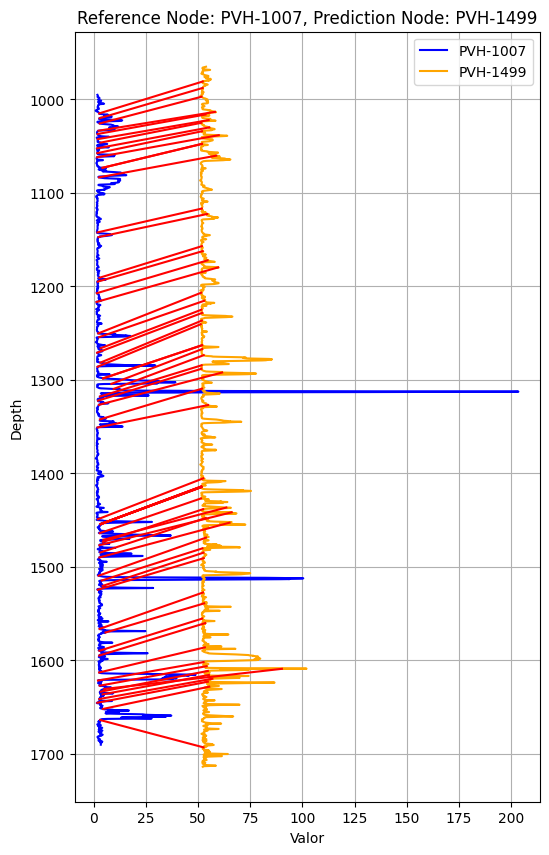

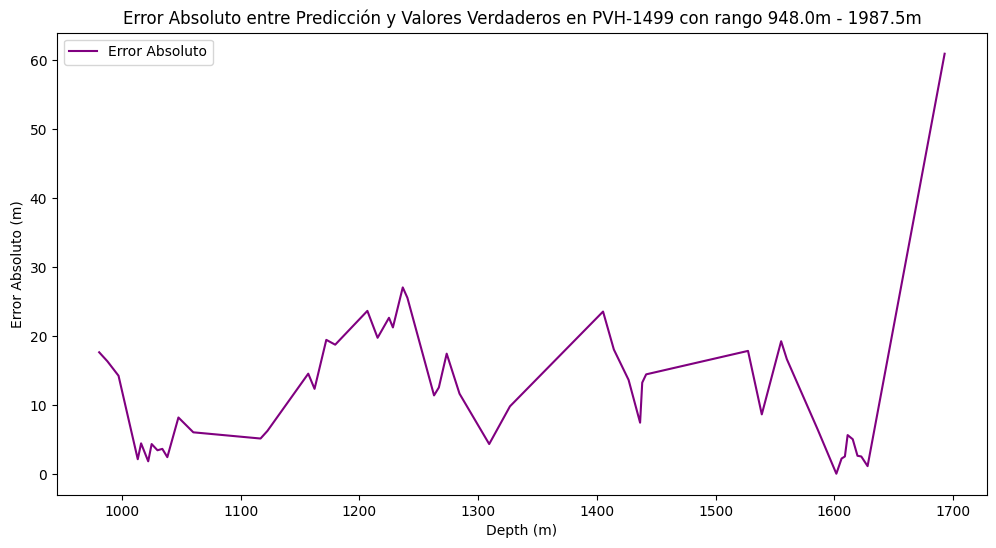

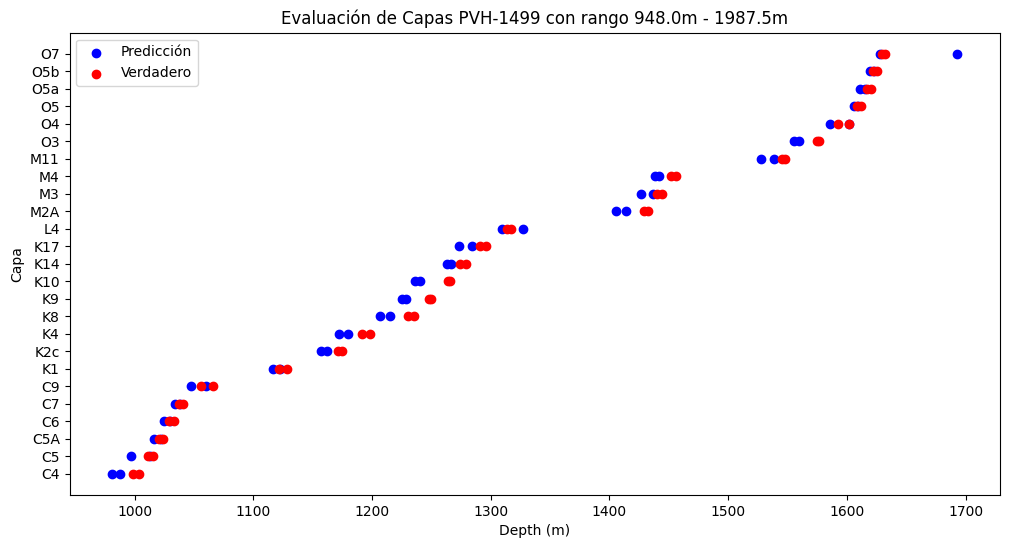

(12.22745600000002, 253.38945024000023)

In [8]:
windows_test(G, "PVH-1007", "PVH-1499", w , show_plots=True)

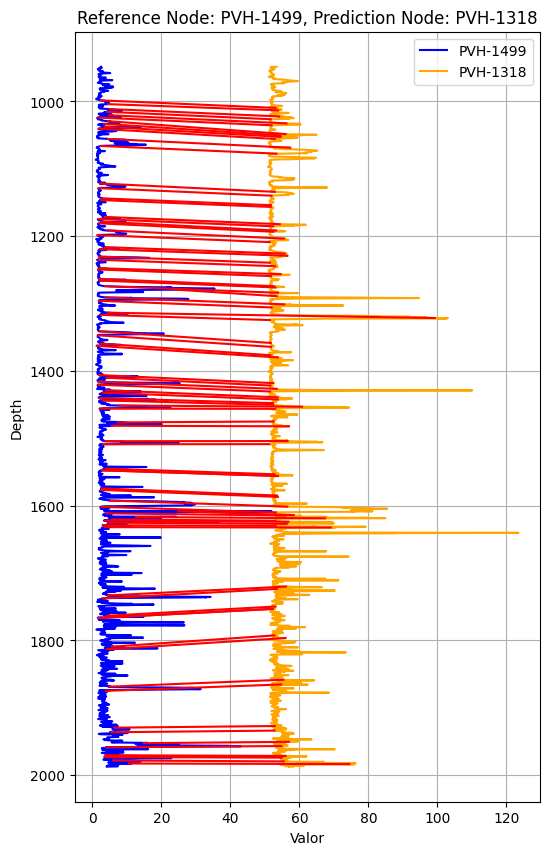

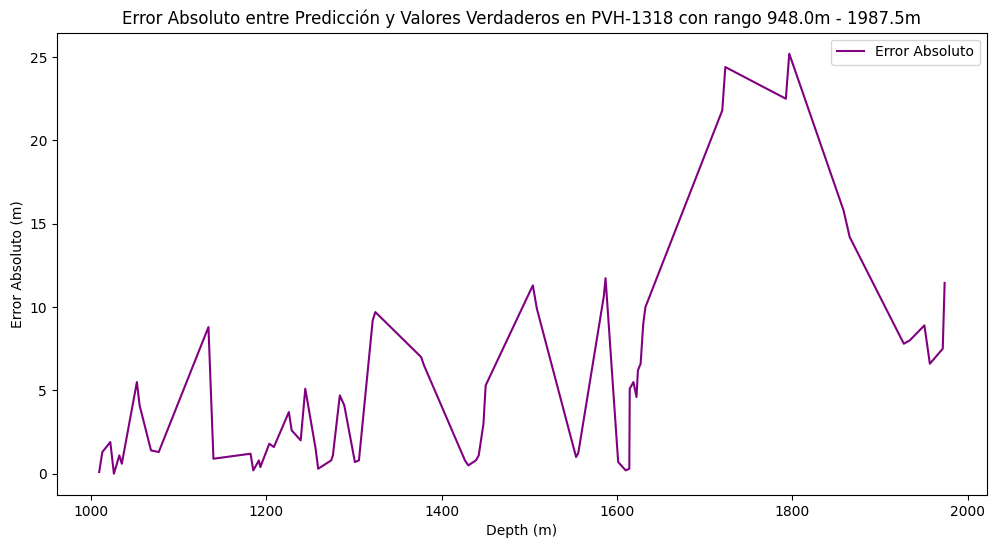

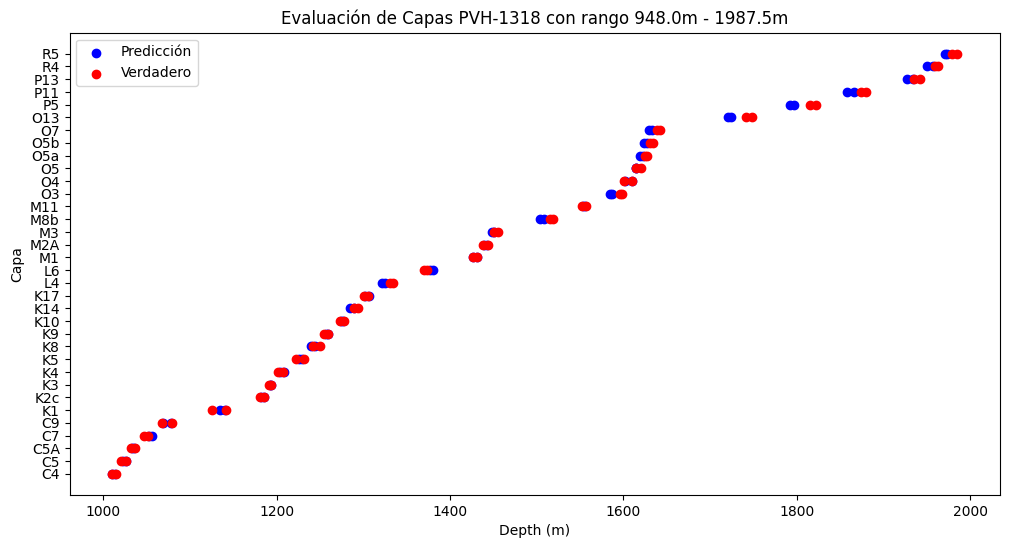

(5.477500000000011, 65.68599264705908)

In [9]:
windows_test(G, "PVH-1499", "PVH-1318", w , show_plots=True)

Conclusion: window optimization is definitely necessary despite the time complexity

In [ ]:
from solve_functions import calc_tops_shortest_jumps, calc_tops_dijkstra
from calc_functions import clear_tops

# window will be derived from the train_window method
win = [1400, 1900, 1400, 1900]
start_node = "PVH-941"
end_node = "PVH-1499"

#calc_tops_dijkstra(G, start_node, end_node, win)
p = calc_tops_shortest_jumps(G, start_node, end_node, win, show_plots = True)
for node in p:
    clear_tops(G, node)

    